This notebook presents a simplistic example of training and exporting a text classifier suitable for use with Il Bufalometro.

# Prepare Data

For this example we shall use a famous example `Reuters news` dataset and train a classifier to discriminate between agriculture-related and business-related news.

The actual models used in Bufalometro were trained on actually relevant corpora, of course.

In [1]:
import nltk
from nltk.corpus import reuters
nltk.download('reuters')

positives = [reuters.raw(d) for d in reuters.fileids(["crude", "barley", "coconut", "corn", "grain"])]
negatives = [reuters.raw(d) for d in reuters.fileids("acq")]

[nltk_data] Downloading package reuters to /home/ubuntu/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


We omit the exploratory analysis step, as it is outside the scope of this notebook. Just note that the Reuters articles are rather clean, in general, and the dataset we chose is reasonably balanced:

In [2]:
len(positives), len(negatives)

(1167, 2369)

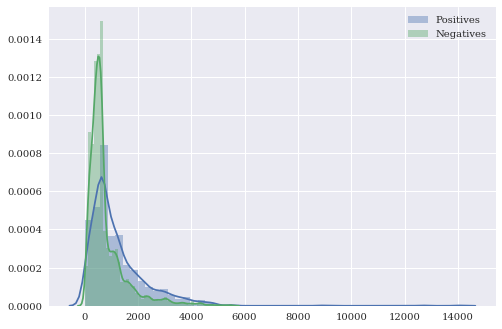

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(font="serif")
sns.distplot([len(t) for t in positives], label="Positives")
sns.distplot([len(t) for t in negatives], label="Negatives");
plt.legend();

Let us collect all the articles into a single list, and create an indicator variable `y`, denoting which articles are the positives.

In [4]:
import numpy as np
X = positives + negatives
y = np.array([1]*len(positives) + [0]*len(negatives))

# Training the Model

At this point we would experiment with various text tokenization, preprocessing and classification approaches. 
In Bufalometro we ended up using a pipeline of a `CountVectorizer` followed by a `MultinomialNB` classifier because it is efficient, works sufficiently well, allows easy visualization of the importance of every word, and well, you don't have time for more at a weekend hackathon.

We packed our model into a class which offers an additional `explain` method for producing the word importances.

In [5]:
from bufalometro.models.nlp import ExplainingWordBasedClassifier
m = ExplainingWordBasedClassifier()

The model's accuracy is nearly perfect:

In [6]:
from sklearn.model_selection import cross_val_score
cross_val_score(m, X, y, scoring='accuracy', cv=5, n_jobs=-1)

array([ 0.98305085,  0.98446328,  0.98727016,  0.97736917,  0.98725212])

Let us train it on the full set and examine a couple of explanations it produces:

In [7]:
m.fit(X, y)

ExplainingWordBasedClassifier(classifier=None, n_levels=4, vectorizer=None)

In [8]:
from IPython.display import HTML
HTML("""
<style>
.neg-3 { background-color: #f33; }
.neg-2 { background-color: #f77; }
.neg-1 { background-color: #faa; }
.pos-3 { background-color: #3f3; }
.pos-2 { background-color: #7f7; }
.pos-1 { background-color: #afa; }
</style>
""")

In [9]:
from bufalometro.models.markup import markup
HTML('<pre>' + markup(X[0], m.explain(X[0])) + '</pre>')

In [10]:
print("Probability of a positive class: %0.6f" % m.predict_proba([X[0]])[0,1])

Probability of a positive class: 1.000000


In [11]:
HTML('<pre>' + markup(X[-1], m.explain(X[-1])) + '</pre>')

In [12]:
print("Probability of a positive class: %0.6f" % m.predict_proba([X[-1]])[0,1])

Probability of a positive class: 0.000000


# Export model

Finally, we export the model for the webapp as a pickle file. The webapp expects that the pickled model implements the `predict_proba` and `explain` methods as shown above.

In [14]:
import pickle
with open('../bufalometro/models/data/reuters-sample.pkl', 'wb') as f:
    pickle.dump(m, f)